In [1105]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

In [1106]:
# Import future ENT appointments
data = pd.read_csv("../future_appts_trans_ENT.csv")
data

,appointment_id,age_deid,bmi_deid,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,substance_misuse,...,appt_date,ethnicity_trans,tfc_name_trans,patient_on_multiple_pathways_trans,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
0,17479744,57,27.45,1,0,1,1,0,0,0,...,2024-06-26,3,7,0,6,0,10,1,0,3
1,17631073,17,27.45,0,1,0,2,0,0,0,...,2024-05-07,3,7,0,5,0,10,1,0,3
2,17659262,27,21.70,0,0,0,4,0,0,0,...,2024-05-07,5,7,0,5,0,10,2,0,2
3,17659348,57,21.70,0,0,0,3,0,0,0,...,2024-05-07,5,7,0,5,0,10,2,0,3
4,17659361,27,27.45,0,1,0,2,0,0,0,...,2024-05-07,3,7,0,5,0,10,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,20183628,47,27.45,0,0,1,2,0,0,0,...,2024-06-19,5,7,0,6,0,10,1,0,1
2561,20183649,57,40.00,0,1,0,1,0,0,0,...,2024-06-08,3,7,0,5,0,10,2,0,3
2562,20183782,32,21.70,0,0,0,4,0,0,0,...,2024-05-25,3,7,0,7,0,10,6,0,1
2563,20183795,62,39.45,0,0,0,1,0,0,0,...,2024-06-17,3,7,0,6,0,10,3,0,1


In [1107]:
# Filter for surgeons & new appointments only
surgeon_new = data[data["reason_display"].isin(["Adult ENT New", "Adult ENT Thyroid New"])]

In [1108]:
# Within the surgeons & new appointments only, filter for very high risk appointments
surgeon_new_very_high = surgeon_new[surgeon_new["did_not_attend_risk_group_trans"] == 4]

In [1109]:
# Count number of unique appointment durations
surgeon_new["appt_duration"].value_counts()

appt_duration
15.0    1962
30.0     198
20.0      33
10.0      17
75.0       3
Name: count, dtype: int64

In [1110]:
# Split out the appointment durations
surgeon_new_10 = surgeon_new[surgeon_new["appt_duration"] == 10]
surgeon_new_15 = surgeon_new[surgeon_new["appt_duration"] == 15]
surgeon_new_20 = surgeon_new[surgeon_new["appt_duration"] == 20]
surgeon_new_30 = surgeon_new[surgeon_new["appt_duration"] == 30]
surgeon_new_75 = surgeon_new[surgeon_new["appt_duration"] == 75]

# Split out the very high risk appointments
surgeon_new_very_high_10 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 10]
surgeon_new_very_high_15 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 15]
surgeon_new_very_high_20 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 20]
surgeon_new_very_high_30 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 30]
surgeon_new_very_high_75 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 75]

In [1111]:
# Group weekswaiting as per NHS guidelines
data["weekswaiting"]
data["weekswaiting_grouped"] = pd.cut(data["weekswaiting"], bins=[0, 17, 51, 76, float("inf")], labels=["0-17", "18-51", "52-77", ">78"])
data[["weekswaiting","weekswaiting_grouped"]]

,weekswaiting,weekswaiting_grouped
0,53.0,52-77
1,82.0,>78
2,55.0,52-77
3,55.0,52-77
4,54.0,52-77
...,...,...
2560,44.0,18-51
2561,13.0,0-17
2562,49.0,18-51
2563,11.0,0-17


### V1: overbook any (other risk levels) into very high risk based on weeks waiting

In [1112]:
# # Sort the appointments by weekswaiting (descending; all except the very high risk ones)
# weekswaiting_desc = surgeon_new[surgeon_new["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
#     # ? Create a new df with >78 weeks waiting - prioritise these patients; but if < # of slots, then fill with 18-52 week patients?



# Sort the individual appointment durations by weekswaiting (descending; all except the very high risk ones)
weekswaiting_desc_10 = surgeon_new_10[surgeon_new_10["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_15 = surgeon_new_15[surgeon_new_15["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_20 = surgeon_new_20[surgeon_new_20["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_30 = surgeon_new_30[surgeon_new_30["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_75 = surgeon_new_75[surgeon_new_75["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)

In [1113]:
# Create queues for the "other risk level" appointments
queue10 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_10[["appointment_id", "appt_date"]].values.tolist()])
queue15 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_15[["appointment_id", "appt_date"]].values.tolist()])
queue20 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_20[["appointment_id", "appt_date"]].values.tolist()])
queue30 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_30[["appointment_id", "appt_date"]].values.tolist()])
queue75 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_75[["appointment_id", "appt_date"]].values.tolist()])

# Sum the duration of queued appointments
queue_time = len(queue10)*10 + len(queue15)*15 + len(queue20)*20 + len(queue30)*30 + len(queue75)*75
print("Sum of starting queue time (V1):", queue_time)

Sum of starting queue time (V1): 32530


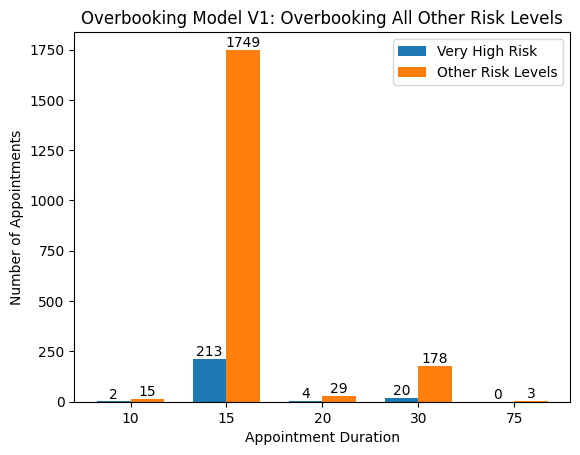

In [1114]:
# Plot number of the very high risk appointments against the queues to compare
# Count the number of appointments for each duration
very_high_counts = [
    len(surgeon_new_very_high_10),
    len(surgeon_new_very_high_15),
    len(surgeon_new_very_high_20),
    len(surgeon_new_very_high_30),
    len(surgeon_new_very_high_75),
]

other_risk_counts = [
    len(queue10),
    len(queue15),
    len(queue20),
    len(queue30),
    len(queue75),
]

# Define the durations
durations = [10, 15, 20, 30, 75]

# Plot the data
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Bar positions
ind = range(len(durations))

# Create the bar plots
bars1 = ax.bar(ind, very_high_counts, width, label="Very High Risk")
bars2 = ax.bar([i + width for i in ind], other_risk_counts, width, label="Other Risk Levels")

# Add labels, title, and legend
ax.set_xlabel("Appointment Duration")
ax.set_ylabel("Number of Appointments")
ax.set_title("Overbooking Model V1: Overbooking All Other Risk Levels")
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(durations)
ax.legend()

# Add data values on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

for bar in bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

# Display the plot
plt.show()

In [1115]:
# Function to overbook the very high risk appointments
def overbook_appointments(very_high_group, queue):
    overbooked_appointments = []
    for index, very_high_appt in very_high_group.iterrows():
        very_high_date = pd.to_datetime(very_high_appt["appt_date"])
        overbooked = False
        # Create a new, temporary queue to hold appointments that are not suitable for the current very_high_appt for later evaluation
        temp_queue = deque()
        
        while queue:
            # Pop the earliest appointment from the queue
            earliest_appointment_id, earliest_date = queue.popleft()
            # Check if the very_high_date is earlier than the earliest_date
            if very_high_date < earliest_date:
                # Overbook the very high risk slot with the remaining appointment
                overbooked_appointments.append((very_high_appt["appointment_id"], earliest_appointment_id))
                overbooked = True
                break
            else:
                # If the date is not suitable, move the appointment to the temporary queue
                temp_queue.append((earliest_appointment_id, earliest_date))
        
        # Merge the temporary queue back into the original queue
        queue.extendleft(reversed(temp_queue))
        
        if not overbooked:
            # No more appointments to overbook
            overbooked_appointments.append((very_high_appt["appointment_id"], None))
    
    return overbooked_appointments

# Overbook each very high risk appointment duration group
overbooked_10 = overbook_appointments(surgeon_new_very_high_10, queue10)
overbooked_15 = overbook_appointments(surgeon_new_very_high_15, queue15)
overbooked_20 = overbook_appointments(surgeon_new_very_high_20, queue20)
overbooked_30 = overbook_appointments(surgeon_new_very_high_30, queue30)
overbooked_75 = overbook_appointments(surgeon_new_very_high_75, queue75)

# Combine all overbooked results
all_overbooked_appointments = overbooked_10 + overbooked_15 + overbooked_20 + overbooked_30 + overbooked_75

# Convert to DataFrame
overbooked_df = pd.DataFrame(all_overbooked_appointments, columns=["very_high_appt_id", "overbooked_appt_id"])
overbooked_df

,very_high_appt_id,overbooked_appt_id
0,19853208,19971567.0
1,20111728,NaN
2,17671208,17671294.0
3,17901062,17667391.0
4,18011196,20112378.0
...,...,...
234,19938829,20141614.0
235,19971221,19881525.0
236,19972250,20056268.0
237,20055757,20055807.0


In [1116]:
# Check if any duplicated overbooked appointments
overbooked_df.dropna(subset=["overbooked_appt_id"])[overbooked_df.dropna(subset=["overbooked_appt_id"]).duplicated("overbooked_appt_id", keep=False)]

,very_high_appt_id,overbooked_appt_id


In [1117]:
# Check the funtion works properly by evaluating 10-minute appointments
print(overbooked_10)
print(len(overbooked_10))
print(len(surgeon_new_very_high_10))
print(len(queue10))


[(19853208, 19971567), (20111728, None)]
2
2
14


In [1118]:
# # Function to overbook the very high risk appointments - with multiple queues ==> returns same results as appts in queue > # of very high risk appts
# def overbook_appointments_multi_queue(very_high_group, queues):
#     overbooked_appointments = []
#     for index, very_high_appt in very_high_group.iterrows():
#         very_high_date = pd.to_datetime(very_high_appt["appt_date"])
#         overbooked = False
#         for queue in queues:
#             temp_queue = deque()  # Temporary queue to hold appointments that are not suitable for the current very_high_appt
#             while queue and not overbooked:
#                 # Pop the earliest appointment from the queue
#                 earliest_appointment_id, earliest_date = queue.popleft()
#                 # Check if the very_high_date is earlier than the earliest_date
#                 if very_high_date < earliest_date:
#                     # Overbook the very high risk slot with the remaining appointment
#                     overbooked_appointments.append((very_high_appt["appointment_id"], earliest_appointment_id))
#                     overbooked = True
#                     break
#                 else:
#                     # If the date is not suitable, move the appointment to the temporary queue
#                     temp_queue.append((earliest_appointment_id, earliest_date))
#             # Merge the temporary queue back into the original queue
#             queue.extendleft(reversed(temp_queue))
#             if overbooked:
#                 break
#         if not overbooked:
#             # No more appointments to overbook
#             overbooked_appointments.append((very_high_appt["appointment_id"], None))
#     return overbooked_appointments

# # Define separate queues by including the "shorter" queues
# queues_10 = [queue10]
# queues_15 = [queue15, queue10]
# queues_20 = [queue20, queue15, queue10]
# queues_30 = [queue30, queue20, queue15, queue10]
# queues_75 = [queue75, queue30, queue20, queue15, queue10]

# # Overbook each very high risk appointment duration group
# overbooked_10 = overbook_appointments_multi_queue(surgeon_new_very_high_10, queues_10)
# overbooked_15 = overbook_appointments_multi_queue(surgeon_new_very_high_15, queues_15)
# overbooked_20 = overbook_appointments_multi_queue(surgeon_new_very_high_20, queues_20)
# overbooked_30 = overbook_appointments_multi_queue(surgeon_new_very_high_30, queues_30)
# overbooked_75 = overbook_appointments_multi_queue(surgeon_new_very_high_75, queues_75)

# # Combine all overbooked results
# all_overbooked_appointments = overbooked_10 + overbooked_15 + overbooked_20 + overbooked_30 + overbooked_75

# # Convert to DataFrame
# overbooked_df = pd.DataFrame(all_overbooked_appointments, columns=["very_high_appt_id", "overbooked_appt_id"])
# overbooked_df

In [1119]:
# Calculate time gap of the overbooked appointments (original vs new/overbooked)

# Append appointment dates to the overbooked_df
# 1. For the very high risk appointments
overbooked_df = pd.merge(overbooked_df, 
                            data[["appointment_id", "appt_date", "did_not_attend_risk"]].rename(columns={"appt_date": "very_high_appt_date",
                                                                                                                          "did_not_attend_risk": "very_high_dna_risk"}), 
                            left_on="very_high_appt_id", 
                            right_on="appointment_id", 
                            how="left").drop(columns=["appointment_id"])
# 2. For the overbooked appointments (incl. appt duration & DNA risk score)
overbooked_df = pd.merge(overbooked_df,
                            data[["appointment_id", "appt_date", "did_not_attend_risk", "appt_duration"]].rename(columns={"appt_date": "original_overbooked_appt_date",
                                                                                                                          "did_not_attend_risk": "original_overbooked_dna_risk"}),
                            left_on="overbooked_appt_id",
                            right_on="appointment_id",
                            how="left").drop(columns=["appointment_id"])

# Calculate the time gap between the original and overbooked appointments
overbooked_df["time_gap_days"] = (pd.to_datetime(overbooked_df["original_overbooked_appt_date"]) - pd.to_datetime(overbooked_df["very_high_appt_date"])).dt.days

overbooked_df

,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_dna_risk,appt_duration,time_gap_days
0,19853208,19971567.0,2025-01-29,0.619074,2025-01-30,0.344912,10.0,1.0
1,20111728,NaN,2025-04-02,0.656163,NaN,NaN,NaN,NaN
2,17671208,17671294.0,2024-05-20,0.710675,2024-05-23,0.318434,15.0,3.0
3,17901062,17667391.0,2024-05-09,0.455411,2024-05-20,0.261759,15.0,11.0
4,18011196,20112378.0,2024-05-23,0.775510,2025-03-07,0.275752,15.0,288.0
...,...,...,...,...,...,...,...,...
234,19938829,20141614.0,2025-04-15,0.473121,2025-05-06,0.179040,30.0,21.0
235,19971221,19881525.0,2025-04-15,0.489043,2025-04-24,0.291788,30.0,9.0
236,19972250,20056268.0,2025-05-29,0.461040,2025-07-24,0.244307,30.0,56.0
237,20055757,20055807.0,2025-07-03,0.793514,2025-07-17,0.408785,30.0,14.0


In [1120]:
# Calculate the average time gap
print("Avg. time gap (V1):", overbooked_df["time_gap_days"].mean())

Avg. time gap (V1): 34.75949367088607


In [1121]:
# Count the remaining appointments in each queue
remaining_10 = len(queue10) * 10
remaining_15 = len(queue15) * 15
remaining_20 = len(queue20) * 20
remaining_30 = len(queue30) * 30
remaining_75 = len(queue75) * 75

# Sum the remaining appointments
remainder_queue_time = remaining_10 + remaining_15 + remaining_20 + remaining_30 + remaining_75
remainder_queue_time

# Sum the duration of the overbooked appointments
print("Sum of overbooked duration (V1):", overbooked_df["appt_duration"].sum())

# Calculate the total duration of the overbooked appointments utilised
print("Sum of queue utilised (V1):", queue_time - remainder_queue_time)

Sum of overbooked duration (V1): 3870.0
Sum of queue utilised (V1): 3870


In [1122]:
# Calculate probability of clinic overtime
overbooked_df["joint_probability"] = overbooked_df["very_high_dna_risk"] * overbooked_df["original_overbooked_dna_risk"]

# Calculate the mean joint probability
print("Mean joint probability (V1):", overbooked_df["joint_probability"].mean())


Mean joint probability (V1): 0.1547810875387665


In [1123]:
# Calculate estimated clinic overtime
overbooked_df["clinic_overtime"] = overbooked_df["joint_probability"] * (overbooked_df["appt_duration"]*2)

# Calculate the mean clinic overtime
print("Mean clinic overtime (per appointment scenario) (V1):", overbooked_df["clinic_overtime"].mean())

Mean clinic overtime (per appointment scenario) (V1): 5.059345923967997


### V2: overbook low & moderate risks into very high risk based on weeks waiting

In [1124]:
# Sort the individual appointment durations by weekswaiting (low & moderate risk)
weekswaiting_desc_10_v2 = surgeon_new_10[(surgeon_new_10["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_10["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_15_v2 = surgeon_new_15[(surgeon_new_15["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_15["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_20_v2 = surgeon_new_20[(surgeon_new_20["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_20["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_30_v2 = surgeon_new_30[(surgeon_new_30["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_30["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_75_v2 = surgeon_new_75[(surgeon_new_75["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_75["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)

# Create queues for the "other risk level" appointments
queue10_v2 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_10_v2[["appointment_id", "appt_date"]].values.tolist()])
queue15_v2 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_15_v2[["appointment_id", "appt_date"]].values.tolist()])
queue20_v2 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_20_v2[["appointment_id", "appt_date"]].values.tolist()])
queue30_v2 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_30_v2[["appointment_id", "appt_date"]].values.tolist()])
queue75_v2 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_75_v2[["appointment_id", "appt_date"]].values.tolist()])

# Sum the duration of queued appointments
queue_time_v2 = len(queue10_v2)*10 + len(queue15_v2)*15 + len(queue20_v2)*20 + len(queue30_v2)*30 + len(queue75_v2)*75
print("Sum of starting queue time (V2):", queue_time_v2)




Sum of starting queue time (V2): 8880


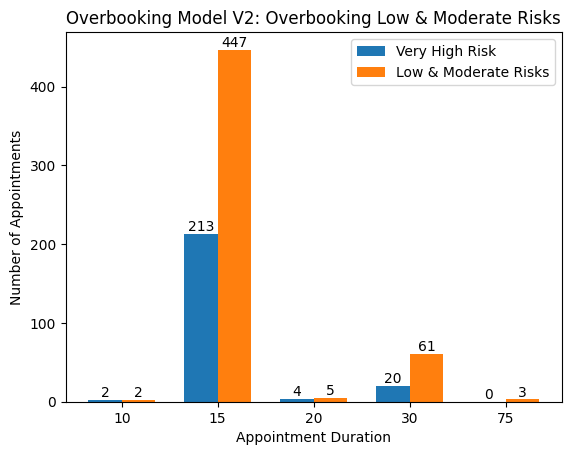

In [1125]:
# Plot number of the very high risk appointments against the queues to compare
# Count the number of appointments for each duration
very_high_counts = [
    len(surgeon_new_very_high_10),
    len(surgeon_new_very_high_15),
    len(surgeon_new_very_high_20),
    len(surgeon_new_very_high_30),
    len(surgeon_new_very_high_75),
]

other_risk_counts = [
    len(queue10_v2),
    len(queue15_v2),
    len(queue20_v2),
    len(queue30_v2),
    len(queue75_v2),
]

# Define the durations
durations = [10, 15, 20, 30, 75]

# Plot the data
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Bar positions
ind = range(len(durations))

# Create the bar plots
bars1 = ax.bar(ind, very_high_counts, width, label="Very High Risk")
bars2 = ax.bar([i + width for i in ind], other_risk_counts, width, label="Low & Moderate Risks")

# Add labels, title, and legend
ax.set_xlabel("Appointment Duration")
ax.set_ylabel("Number of Appointments")
ax.set_title("Overbooking Model V2: Overbooking Low & Moderate Risks")
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(durations)
ax.legend()

# Add data values on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

for bar in bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

# Display the plot
plt.show()

In [1126]:
# Overbook each very high risk appointment duration group by using the same overbooking function as V1
overbooked_10_v2 = overbook_appointments(surgeon_new_very_high_10, queue10_v2)
overbooked_15_v2 = overbook_appointments(surgeon_new_very_high_15, queue15_v2)
overbooked_20_v2 = overbook_appointments(surgeon_new_very_high_20, queue20_v2)
overbooked_30_v2 = overbook_appointments(surgeon_new_very_high_30, queue30_v2)
overbooked_75_v2 = overbook_appointments(surgeon_new_very_high_75, queue75_v2)

# Combine all overbooked results
all_overbooked_appointments_v2 = overbooked_10_v2 + overbooked_15_v2 + overbooked_20_v2 + overbooked_30_v2 + overbooked_75_v2

# Convert to DataFrame
overbooked_df_v2 = pd.DataFrame(all_overbooked_appointments_v2, columns=["very_high_appt_id", "overbooked_appt_id"])
overbooked_df_v2



,very_high_appt_id,overbooked_appt_id
0,19853208,NaN
1,20111728,NaN
2,17671208,20026346.0
3,17901062,20026219.0
4,18011196,20025984.0
...,...,...
234,19938829,NaN
235,19971221,NaN
236,19972250,NaN
237,20055757,NaN


In [1127]:
# Calculate time gap of the overbooked appointments (original vs new/overbooked)

# Append appointment dates to the overbooked_df
# 1. For the very high risk appointments
overbooked_df_v2 = pd.merge(overbooked_df_v2, 
                            data[["appointment_id", "appt_date", "did_not_attend_risk"]].rename(columns={"appt_date": "very_high_appt_date",
                                                                                                         "did_not_attend_risk": "very_high_dna_risk"}), 
                            left_on="very_high_appt_id", 
                            right_on="appointment_id", 
                            how="left").drop(columns=["appointment_id"])
# 2. For the overbooked appointments (incl. appt duration & DNA risk score)
overbooked_df_v2 = pd.merge(overbooked_df_v2,
                            data[["appointment_id", "appt_date", "did_not_attend_risk", "appt_duration"]].rename(columns={"appt_date": "original_overbooked_appt_date",
                                                                                                                          "did_not_attend_risk": "original_overbooked_dna_risk"}),
                            left_on="overbooked_appt_id",
                            right_on="appointment_id",
                            how="left").drop(columns=["appointment_id"])

# Calculate the time gap between the original and overbooked appointments
overbooked_df_v2["time_gap_days"] = (pd.to_datetime(overbooked_df_v2["original_overbooked_appt_date"]) - pd.to_datetime(overbooked_df_v2["very_high_appt_date"])).dt.days

overbooked_df_v2

,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_dna_risk,appt_duration,time_gap_days
0,19853208,NaN,2025-01-29,0.619074,NaN,NaN,NaN,NaN
1,20111728,NaN,2025-04-02,0.656163,NaN,NaN,NaN,NaN
2,17671208,20026346.0,2024-05-20,0.710675,2024-08-27,0.061545,15.0,99.0
3,17901062,20026219.0,2024-05-09,0.455411,2025-01-15,0.175142,15.0,251.0
4,18011196,20025984.0,2024-05-23,0.775510,2024-08-20,0.081328,15.0,89.0
...,...,...,...,...,...,...,...,...
234,19938829,NaN,2025-04-15,0.473121,NaN,NaN,NaN,NaN
235,19971221,NaN,2025-04-15,0.489043,NaN,NaN,NaN,NaN
236,19972250,NaN,2025-05-29,0.461040,NaN,NaN,NaN,NaN
237,20055757,NaN,2025-07-03,0.793514,NaN,NaN,NaN,NaN


In [1128]:
# Calculate the average time gap
print("Avg. time gap (V2):", overbooked_df_v2["time_gap_days"].mean())

Avg. time gap (V2): 27.114155251141554


In [1129]:
# Count the remaining appointments in each queue
remaining_10_v2 = len(queue10_v2) * 10
remaining_15_v2 = len(queue15_v2) * 15
remaining_20_v2 = len(queue20_v2) * 20
remaining_30_v2 = len(queue30_v2) * 30
remaining_75_v2 = len(queue75_v2) * 75

# Sum the remaining appointments
remainder_queue_time_v2 = remaining_10_v2 + remaining_15_v2 + remaining_20_v2 + remaining_30_v2 + remaining_75_v2
remainder_queue_time_v2

# Sum the duration of the overbooked appointments
print("Sum of overbooked duration (V2):", overbooked_df_v2["appt_duration"].sum())

# Calculate the total duration of the overbooked appointments utilised
print("Sum of queue utilised (V2):", queue_time_v2 - remainder_queue_time_v2)

Sum of overbooked duration (V2): 3525.0
Sum of queue utilised (V2): 3525


In [1130]:
# Calculate probability of clinic overtime
overbooked_df_v2["joint_probability"] = overbooked_df_v2["very_high_dna_risk"] * overbooked_df_v2["original_overbooked_dna_risk"]

# Calculate the mean joint probability
print("Mean joint probability (V2):", overbooked_df_v2["joint_probability"].mean())

Mean joint probability (V2): 0.08603446505987451


In [1131]:
# Calculate estimated clinic overtime
overbooked_df_v2["clinic_overtime"] = overbooked_df_v2["joint_probability"] * (overbooked_df_v2["appt_duration"]*2)

# Calculate the mean clinic overtime
print("Mean clinic overtime (per appointment scenario) (V2):", overbooked_df_v2["clinic_overtime"].mean())

Mean clinic overtime (per appointment scenario) (V2): 2.7943643837621726


### V3: under-overbook (eg. overbook a 20min in a 30min slot) to avoid clinic overtime; low + moderate + high

In [1132]:
# Using the same queues and function as V1
# Recreate the queues for the "other risk level" appointments
queue10_v3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_10[["appointment_id", "appt_date"]].values.tolist()])
queue15_v3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_15[["appointment_id", "appt_date"]].values.tolist()])
queue20_v3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_20[["appointment_id", "appt_date"]].values.tolist()])
queue30_v3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_30[["appointment_id", "appt_date"]].values.tolist()])
queue75_v3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_75[["appointment_id", "appt_date"]].values.tolist()])

# Sum the duration of queued appointments
queue_time_v3 = len(queue10_v3)*10 + len(queue15_v3)*15 + len(queue20_v3)*20 + len(queue30_v3)*30 + len(queue75_v3)*75
print("Sum of starting queue time (V3):", queue_time_v3)

Sum of starting queue time (V3): 32530


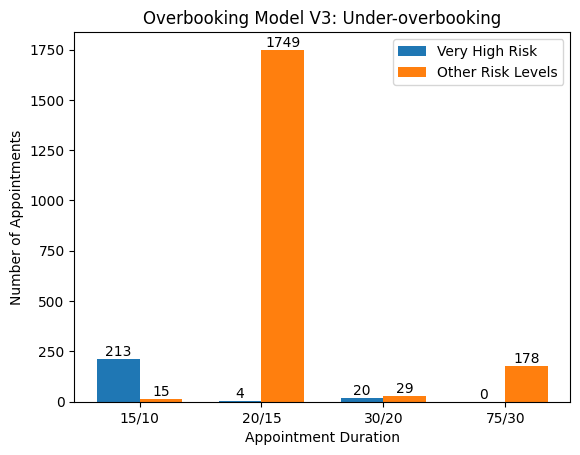

In [1133]:
# Plot number of the very high risk appointments against the queues to compare
# Count the number of appointments for each duration
very_high_counts = [
    # len(surgeon_new_very_high_10),
    len(surgeon_new_very_high_15),
    len(surgeon_new_very_high_20),
    len(surgeon_new_very_high_30),
    len(surgeon_new_very_high_75),
]

other_risk_counts = [
    len(queue10_v3),
    len(queue15_v3),
    len(queue20_v3),
    len(queue30_v3),
    # len(queue75_v3),
]

# Define the durations
durations = ["15/10", "20/15", "30/20", "75/30"]

# Plot the data
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Bar positions
ind = range(len(durations))

# Create the bar plots
bars1 = ax.bar(ind, very_high_counts, width, label="Very High Risk")
bars2 = ax.bar([i + width for i in ind], other_risk_counts, width, label="Other Risk Levels")

# Add labels, title, and legend
ax.set_xlabel("Appointment Duration")
ax.set_ylabel("Number of Appointments")
ax.set_title("Overbooking Model V3: Under-overbooking")
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(durations)
ax.legend()

# Add data values on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

for bar in bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

# Display the plot
plt.show()

In [1134]:
# Overbook each very high risk appointment duration group
# Not possible for 10-minute appiontments as no shorter duration appointments available
overbooked_15_v3 = overbook_appointments(surgeon_new_very_high_15, queue10_v3)
overbooked_20_v3 = overbook_appointments(surgeon_new_very_high_20, queue15_v3)
overbooked_30_v3 = overbook_appointments(surgeon_new_very_high_30, queue20_v3)
overbooked_75_v3 = overbook_appointments(surgeon_new_very_high_75, queue30_v3)

# Combine all overbooked results
all_overbooked_appointments_v3 = overbooked_15_v3 + overbooked_20_v3 + overbooked_30_v3 + overbooked_75_v3

# Convert to DataFrame
overbooked_df_v3 = pd.DataFrame(all_overbooked_appointments_v3, columns=["very_high_appt_id", "overbooked_appt_id"])

# Append appointment dates to the overbooked_df
# 1. For the very high risk appointments
overbooked_df_v3 = pd.merge(overbooked_df_v3, 
                            data[["appointment_id", "appt_date", "appt_duration" ,"did_not_attend_risk"]].rename(columns={"appt_date": "very_high_appt_date",
                                                                                                                          "appt_duration": "very_high_appt_duration",
                                                                                                                          "did_not_attend_risk": "very_high_dna_risk"}), 
                            left_on="very_high_appt_id", 
                            right_on="appointment_id", 
                            how="left").drop(columns=["appointment_id"])
# 2. For the overbooked appointments (incl. appt duration & DNA risk score)
overbooked_df_v3 = pd.merge(overbooked_df_v3,
                            data[["appointment_id", "appt_date", "appt_duration", "did_not_attend_risk"]].rename(columns={"appt_date": "original_overbooked_appt_date",
                                                                                                                          "appt_duration": "original_overbooked_appt_duration",
                                                                                                                          "did_not_attend_risk": "original_overbooked_dna_risk"}),
                            left_on="overbooked_appt_id",
                            right_on="appointment_id",
                            how="left").drop(columns=["appointment_id"])


# Calculate the time gap between the original and overbooked appointments
overbooked_df_v3["time_gap_days"] = (pd.to_datetime(overbooked_df_v3["original_overbooked_appt_date"]) - pd.to_datetime(overbooked_df_v3["very_high_appt_date"])).dt.days

overbooked_df_v3

,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_appt_duration,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_appt_duration,original_overbooked_dna_risk,time_gap_days
0,17671208,18616180.0,2024-05-20,15.0,0.710675,2024-06-20,10.0,0.384087,31.0
1,17901062,18296387.0,2024-05-09,15.0,0.455411,2024-07-10,10.0,0.246540,62.0
2,18011196,18748587.0,2024-05-23,15.0,0.775510,2024-08-12,10.0,0.209423,81.0
3,18012765,18867602.0,2024-05-02,15.0,0.574464,2024-09-11,10.0,0.241837,132.0
4,18017248,19268866.0,2024-05-29,15.0,0.582589,2024-09-30,10.0,0.243421,124.0
...,...,...,...,...,...,...,...,...,...
232,19938829,19664457.0,2025-04-15,30.0,0.473121,2025-07-07,20.0,0.257243,83.0
233,19971221,19664473.0,2025-04-15,30.0,0.489043,2025-07-14,20.0,0.277879,90.0
234,19972250,19517889.0,2025-05-29,30.0,0.461040,2025-06-09,20.0,0.413918,11.0
235,20055757,19826747.0,2025-07-03,30.0,0.793514,2025-08-18,20.0,0.312378,46.0


In [1135]:
# Calculate the average time gap
print("Avg. time gap (V3):", overbooked_df_v3["time_gap_days"].mean())

Avg. time gap (V3): 103.94736842105263


In [1136]:
# Count the remaining appointments in each queue
remaining_10_v3 = len(queue10_v3) * 10
remaining_15_v3 = len(queue15_v3) * 15
remaining_20_v3 = len(queue20_v3) * 20
remaining_30_v3 = len(queue30_v3) * 30
remaining_75_v3 = len(queue75_v3) * 75

# Sum the remaining appointments
remainder_queue_time_v3 = remaining_10_v3 + remaining_15_v3 + remaining_20_v3 + remaining_30_v3 + remaining_75_v3
remainder_queue_time_v3

# Sum the duration of the overbooked appointments
print("Sum of overbooked duration (V3):", overbooked_df_v3["original_overbooked_appt_duration"].sum())

# Calculate the total duration of the overbooked appointments utilised
print("Sum of queue utilised (V3):", queue_time_v3 - remainder_queue_time_v3)

Sum of overbooked duration (V3): 600.0
Sum of queue utilised (V3): 600


In [1137]:
# Calculate probability of clinic overtime
overbooked_df_v3["joint_probability"] = overbooked_df_v3["very_high_dna_risk"] * overbooked_df_v3["original_overbooked_dna_risk"]

# Calculate the mean joint probability
print("Mean joint probability (V3):", overbooked_df_v3["joint_probability"].mean())

Mean joint probability (V3): 0.1593634688293736


In [1138]:
# Calculate estimated clinic overtime
overbooked_df_v3["clinic_overtime"] = overbooked_df_v3["joint_probability"] * (overbooked_df_v3["very_high_appt_duration"] + overbooked_df_v3["original_overbooked_appt_duration"])

# Calculate the mean clinic overtime
print("Mean clinic overtime (per appointment scenario) (V3):", overbooked_df_v3["clinic_overtime"].mean())

Mean clinic overtime (per appointment scenario) (V3): 6.379100138477346


### V4: Calculate max capacity (per weekday) for new surgeon appointments and overbook by creating extra time slots 

In [ ]:
# Import historic ENT appointments
historic = pd.read_csv("../historic_first_pred_ENT.csv")
historic.head()

In [ ]:
# Count total duration per day of historic appointments
historic_duration = historic.groupby("appt_date")["appt_duration"].sum().reset_index()
historic_duration

In [ ]:
# Convert to weekdays

# Convert appt_date to datetime
historic_duration["appt_date"] = pd.to_datetime(historic_duration["appt_date"])

# Extract the day of the week
historic_duration["weekday"] = historic_duration["appt_date"].dt.day_name()

# Sum the duration of appointments per day of the week
historic_duration.groupby("weekday")["appt_duration"].sum()

In [ ]:
# Filter for historic surgeons & new appointments only ("Adult ENT New", "Adult ENT Thyroid New", "Adult ENT Emergency Clinic New", "Adult ENT Emergency Nose Fracture New")
historic_surgeon_new = historic[historic["reason_display_trans"].isin([8, 18, 4, 5])]
historic_surgeon_new


In [ ]:
# Total duration per day of historic surgeon & new appointments only
historic_surgeon_new_duration = historic_surgeon_new.groupby("appt_date")["appt_duration"].sum().reset_index()

# Convert appt_date to datetime
historic_surgeon_new_duration["appt_date"] = pd.to_datetime(historic_surgeon_new_duration["appt_date"])

historic_surgeon_new_duration


In [ ]:
# Calculate proportion of surgeon_new out of all historic appointments

# Merge the dfs on appt_date
merged_historic_durations = pd.merge(historic_duration, historic_surgeon_new_duration, on="appt_date", suffixes=("_total", "_surgeon_new"))

# Calculate the proportion
merged_historic_durations["proportion"] = merged_historic_durations["appt_duration_surgeon_new"] / merged_historic_durations["appt_duration_total"]
merged_historic_durations

# Find the mean proportion (i.e. the average proportion of surgeon_new out of all historic appointments)
merged_historic_durations.groupby("weekday")["proportion"].mean()


In [ ]:
# Calculate avg. max minutes per week day for surgeon_new
max_weekday_surgeon_new = merged_historic_durations.groupby("weekday")["appt_duration_total"].sum() * merged_historic_durations.groupby("weekday")["proportion"].mean()
max_weekday_surgeon_new

In [ ]:
# Find out total duration of surgeon_new appointments for the future ENT appointments


### Compare the 4 models

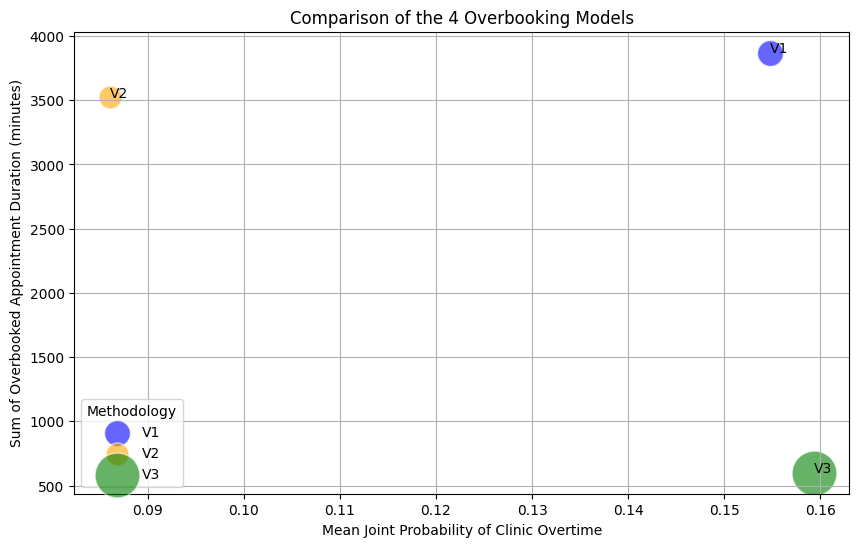

In [1166]:
# Sample data for the three methodologies based on the provided variables
compare_model = {
    'Version': ['V1', 'V2', 'V3'],
    'Mean joint probability': [
        overbooked_df["joint_probability"].mean(), 
        overbooked_df_v2["joint_probability"].mean(), 
        overbooked_df_v3["joint_probability"].mean()
    ],
    'Sum of Overbooked Appointment Duration (minutes)': [
        overbooked_df["appt_duration"].sum(), 
        overbooked_df_v2["appt_duration"].sum(),
        overbooked_df_v3["original_overbooked_appt_duration"].sum()
    ],
    'Avg. time gap (days)': [
        overbooked_df["time_gap_days"].mean(),
        overbooked_df_v2["time_gap_days"].mean(),
        overbooked_df_v3["time_gap_days"].mean()
    ]
}

# Create a DataFrame
df = pd.DataFrame(compare_model)

# Plotting the scatter plot with time gap as size of marker
plt.figure(figsize=(10, 6))

# Scatter plot for each version
colors = ['blue', 'orange', 'green']
for i in range(len(df)):
    plt.scatter(df['Mean joint probability'][i], 
                df['Sum of Overbooked Appointment Duration (minutes)'][i], 
                s=df['Avg. time gap (days)'][i] * 10, # Scale marker size
                color=colors[i],
                alpha=0.6,
                edgecolors="w",
                label=df['Version'][i])

# Adding labels to each point
for i, txt in enumerate(df['Version']):
    plt.annotate(txt, (df['Mean joint probability'][i], df['Sum of Overbooked Appointment Duration (minutes)'][i]), fontsize=10)

plt.xlabel('Mean Joint Probability of Clinic Overtime')
plt.ylabel('Sum of Overbooked Appointment Duration (minutes)')
plt.title('Comparison of the 4 Overbooking Models')
plt.legend(title='Methodology')
plt.grid(True)
plt.show()